In [6]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd

import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import argparse


In [19]:
time = [65]
models = ["GAM","GBM"]
taxas = ["Mammals"]



years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for model in models:
    for taxa in taxas:
        print("Taxa", taxa)
        print("Model", model)
        print("Time", time[0])
        for GCM, bioscen_GCM in zip(GCMs, bioscen_GCMs):
            print("GCM", GCM, "bioscen_GCM", bioscen_GCM)
            for scenario in scenarios:
                print("Scenario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):
                    # Your code here

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = [x.split(".csv")[0] for x in available_file]

                    formatted_names = []

                    for species_name in available_names[:1]:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:1]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue

                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue

                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]
                        disp2 = bioscen_species["dispersal2"]
                        val_disp = z* disp2

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": val_disp})

                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')
                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))

                        num_codes = 0
                        for code in keys: 
                            # Check if the code is "MARINE" and skip land-use filter if it is
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                                #da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                #da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                #binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                #sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                da_landuse["sum_lu_binary"] = sum_lu_binary
                                #da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                #da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                

                        for variable in list(da_landuse.keys()):
                            if variable != "newvalue" and variable != "sum_bin" and variable != "sum_lu_binary":
                                del da_landuse[variable]



Taxa Mammals
Model GAM
Time 65
GCM GFDL-ESM2M bioscen_GCM GFDL.ESM2M
Scenario rcp26
Scenario rcp60
GCM IPSL-CM5A-LR bioscen_GCM IPSL.CM5A-LR
Scenario rcp26
Scenario rcp60
GCM HadGEM2-ES bioscen_GCM HadGEM2.ES
Scenario rcp26
Scenario rcp60
GCM MIROC5 bioscen_GCM MIROC5
Scenario rcp26
Scenario rcp60
Taxa Mammals
Model GBM
Time 65
GCM GFDL-ESM2M bioscen_GCM GFDL.ESM2M
Scenario rcp26
Scenario rcp60
GCM IPSL-CM5A-LR bioscen_GCM IPSL.CM5A-LR
Scenario rcp26
Scenario rcp60
GCM HadGEM2-ES bioscen_GCM HadGEM2.ES
Scenario rcp26
Scenario rcp60
GCM MIROC5 bioscen_GCM MIROC5
Scenario rcp26
Scenario rcp60


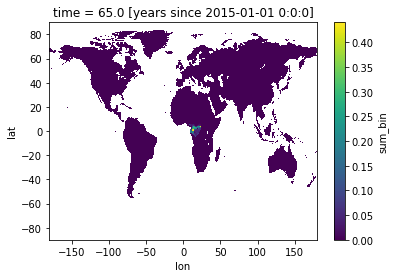

In [20]:
da_landuse["sum_bin"].plot()

In [21]:
diff= da_landuse_no-da_landuse["sum_bin"]

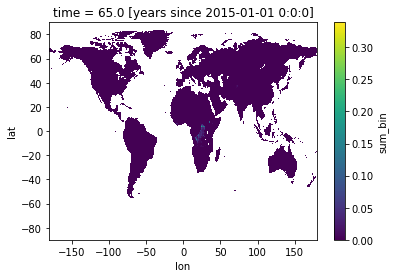

In [22]:
diff.plot()

In [18]:
da_landuse_no = da_landuse["sum_bin"]

In [16]:
#no dispersal limitations

time = [65]
models = ["GAM","GBM"]
taxas = ["Mammals"]



years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for model in models:
    for taxa in taxas:
        print("Taxa", taxa)
        print("Model", model)
        print("Time", time[0])
        for GCM, bioscen_GCM in zip(GCMs, bioscen_GCMs):
            print("GCM", GCM, "bioscen_GCM", bioscen_GCM)
            for scenario in scenarios:
                print("Scenario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):
                    # Your code here

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = [x.split(".csv")[0] for x in available_file]

                    formatted_names = []

                    for species_name in available_names[:1]:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:1]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue

                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue

                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]
                        disp2 = bioscen_species["dispersal2"]
                        val_disp = z* disp2

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})

                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        IUCN['result.code'] = pd.to_numeric(IUCN['result.code'], errors='coerce')
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')
                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))

                        num_codes = 0
                        for code in keys: 
                            # Check if the code is "MARINE" and skip land-use filter if it is
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                                #da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                #da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                #binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                #sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                da_landuse["sum_lu_binary"] = sum_lu_binary
                                #da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                #da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes
                                

                        for variable in list(da_landuse.keys()):
                            if variable != "newvalue" and variable != "sum_bin" and variable != "sum_lu_binary":
                                del da_landuse[variable]



Taxa Mammals
Model GAM
Time 65
GCM GFDL-ESM2M bioscen_GCM GFDL.ESM2M
Scenario rcp26
Scenario rcp60
GCM IPSL-CM5A-LR bioscen_GCM IPSL.CM5A-LR
Scenario rcp26
Scenario rcp60
GCM HadGEM2-ES bioscen_GCM HadGEM2.ES
Scenario rcp26
Scenario rcp60
GCM MIROC5 bioscen_GCM MIROC5
Scenario rcp26
Scenario rcp60
Taxa Mammals
Model GBM
Time 65
GCM GFDL-ESM2M bioscen_GCM GFDL.ESM2M
Scenario rcp26
Scenario rcp60
GCM IPSL-CM5A-LR bioscen_GCM IPSL.CM5A-LR
Scenario rcp26
Scenario rcp60
GCM HadGEM2-ES bioscen_GCM HadGEM2.ES
Scenario rcp26
Scenario rcp60
GCM MIROC5 bioscen_GCM MIROC5
Scenario rcp26
Scenario rcp60
